## Code Fenics

### Importation des modules

In [1]:
from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import random

### Définition des constantes du problème

In [2]:
T = 5.0            # Temps final de la simulation
num_steps = 5000   # Nombre de pas temporels
dt = T / num_steps # Le pas temporel
rho = 1            # densité de l'eau

In [3]:
mu = random.uniform(0.0005, 0.002) # viscosité dynamique du fluide
print(mu)

0.0009306127110618233


### Création des maillages

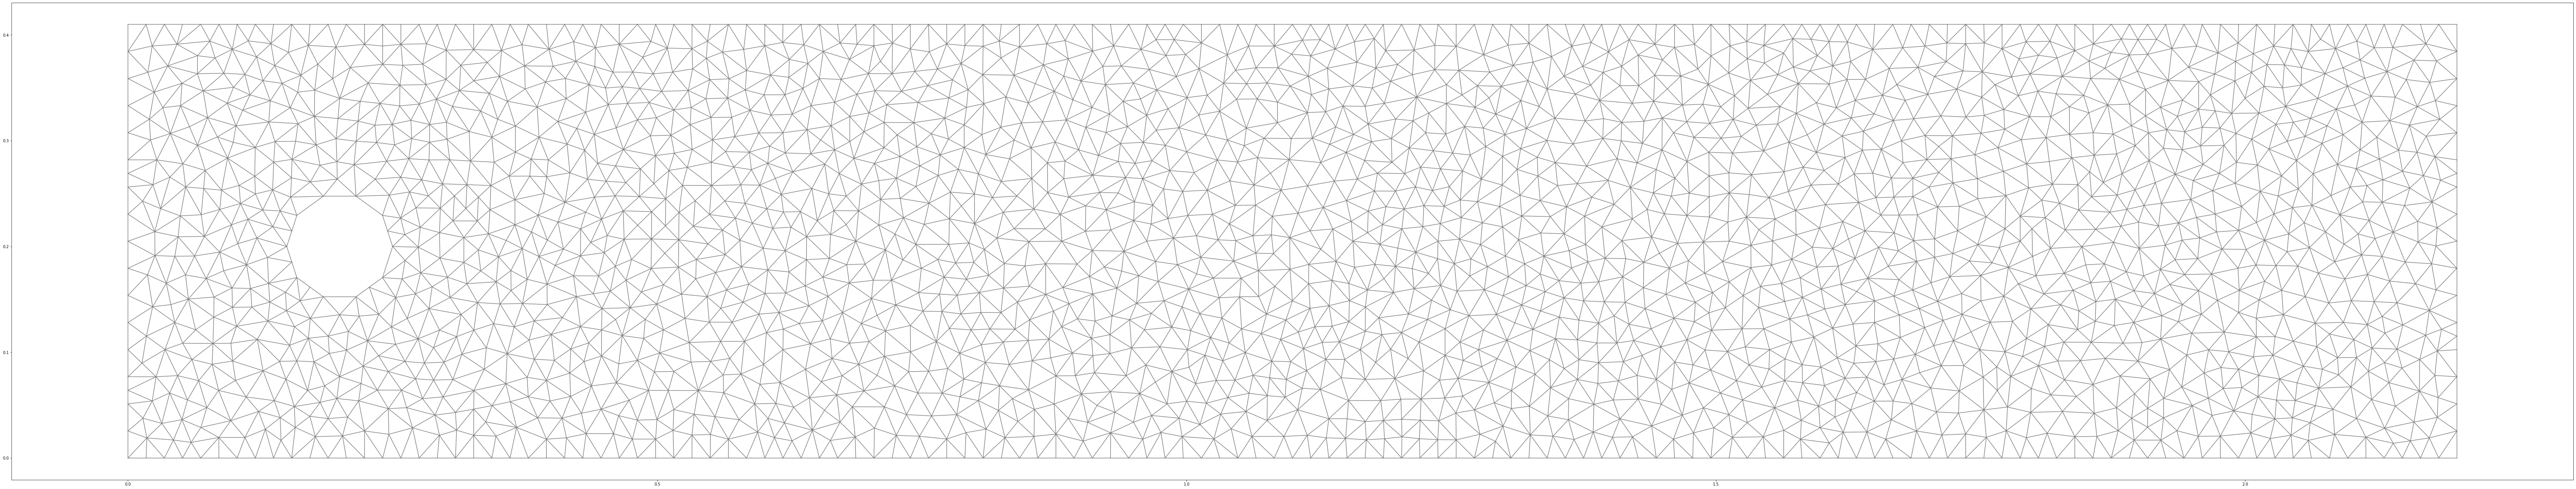

In [4]:
channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05)
domain = channel - cylinder

mesh = generate_mesh(domain, 64) #l'argument 64 indique que nous voulons 64 cellules sur la longueur du canal 
figure = plt.figure(figsize = (120, 120))

plot(mesh)
plt.show()

In [5]:
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

### On définit les frontières
La manière suivante de définir les frontières est équivalente à :

    def boundary(x, on_boundary):
      return near(x[0], 0)


In [6]:
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

# On definit le profil de l'afflux incident 
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

In [7]:
# On veut que la vitesse d'écoulement soit nulles sur les bords des murs et 
# qu'elle soit égale au profil d'excitation sur la face avant
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)

# On veut que la vitesse d'écoulement soit nulles autour des bords de chaques cylindres
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)

bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

### Formulation variationelle

Nous passons maintenant à la définition des formes variationnelles. Il y a trois problèmes variationnels à définir, un pour chaque étape du schéma.

In [8]:
# On définit les fonction de test et d'essai
# Puisque nous avons deux éspaces fonctionnels différents, 
# nous devons créer deux ensembles de fonctions d'essai et de test: c'est ce qui compléxifie beaucoup le problème

u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# On définit les fonction pour les essais au temps d'avant et au temps présent
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

In [9]:
# On définit les constantes utilisées dans la forme variationelle
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

In [10]:
# On définit le gradient symmetrique 
def epsilon(u):
    return sym(nabla_grad(u))

# On définit le tensor de stresse
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# On définit le probleme variationel pour l'étape 1
F1 = rho*dot((u - u_n) / k, v)*dx + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds - dot(f, v)*dx


# FEniCS peut appeler la forme bilinéaire a(u,v) et forme linéaire L(v) par les fonctions lhs et rhs
a1 = lhs(F1)
L1 = rhs(F1)

# On définit le probleme variationel pour l'étape 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# On définit le probleme variationel pour l'étape 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

In [11]:
# matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# On applique les conditions aux frontierss aux matrices
#[bc.apply(A1) for bc in bcu] itère sur tout bc dans la liste bcu. 
# C'est une une boucle qui applique toutes les conditions aux limites sur une seule ligne
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None]

### Résolution et affichages des résultats

t= 0.10100000000000008


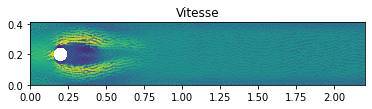

t= 0.5010000000000003


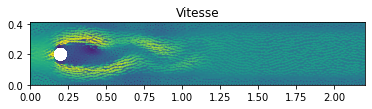

t= 0.7010000000000005


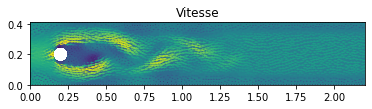

t= 1.2009999999999785


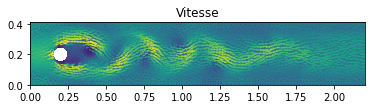

t= 1.5009999999999455


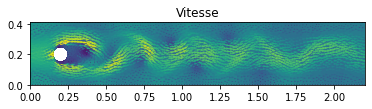

t= 2.1009999999998796


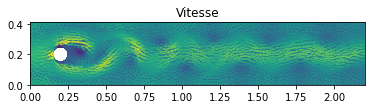

t= 2.5009999999998356


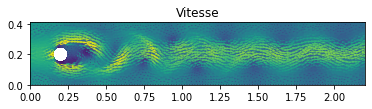

t= 4.980999999999998


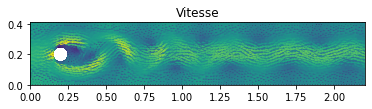

In [13]:
t = 0

# C'est la liste des instants pour lesquels on veut afficher le graphique
L=[100,500,700,1200,1500,2100,2500,4980]

for n in range(num_steps):

    # Mise a jour du temps
    t += dt

    # Etape 1 : Tentative de vitesse
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg') # on precise la méthode itérative de resolution que l'on souhaite

    # Etape 2: Correction de la pression
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Etape 3: Corection de la vitesse
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Affichage de la solution
    if n in L:
        print('t=',t)
        #figure = plt.figure(figsize = (120, 120))
        plot(p_, title='Pression')
        plot(u_, title='Vitesse')
        plt.savefig('vitesse+pression'+ str(n) +'.png',dpi=100)
        plt.show()
    
    # Mise a jour des solution precedentes
    u_n.assign(u_)
    p_n.assign(p_)
